# 1- Data Acquisition & Processing

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
!pip install monai streamlit torchvision matplotlib numpy pandas seaborn scikit-learn Pillow grad-cam

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 122.8 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
INFO: pip is looking at multiple versions of torchvision to determine which version is compatible with other requirements. This could take a while.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.7/2.7 MB 102.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.0/10.0 MB 139.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.2/7.2 MB 130.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 766.6/766.6 MB 2.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 133.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 107.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 63.0 MB/s eta 0:00:00


In [12]:
import os
import glob
import numpy as np
from PIL import Image
import torch
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
import monai
from monai.data import Dataset
from monai.transforms import (
    Compose,
    LoadImage,
    EnsureChannelFirst,
    ScaleIntensity,
    RandFlip,
    RandRotate,
    RandZoom,
    Resize,
    ToTensor,
    EnsureType,
)

In [13]:
andrew_path = '/content/drive/MyDrive/6- CMPE 257 Machine Learning/'
nic_path = '/content/drive/My Drive/'
carlos_path = ''


train_dir = "Final Project/data/chest_xray/train"
val_dir   = "Final Project/data/chest_xray/val"
test_dir  = "Final Project/data/chest_xray/test"

class ChestXRayDataset(Dataset):
    def __init__(self, image_dir, transform=None, target_size=(224, 224), user_path=andrew_path):
        self.image_files = []
        self.labels = []
        self.transform = transform
        self.target_size = target_size

        image_dir = os.path.join(user_path, image_dir)

        # Load normal images
        normal_path = os.path.join(image_dir, "NORMAL")
        if os.path.exists(normal_path):
            for img_file in glob.glob(os.path.join(normal_path, "*.jpeg")):
                self.image_files.append(img_file)
                self.labels.append(0)

        # Load pneumonia images
        pneumonia_path = os.path.join(image_dir, "PNEUMONIA")
        if os.path.exists(pneumonia_path):
            for img_file in glob.glob(os.path.join(pneumonia_path, "*.jpeg")):
                self.image_files.append(img_file)
                self.labels.append(1)

        print(f"Found {len(self.image_files)} images in {image_dir}")

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        img_path = self.image_files[idx]
        label = self.labels[idx]

        try:
            # Load and resize image
            image = Image.open(img_path).convert('L')  # Convert to grayscale
            image = image.resize(self.target_size)  # Resize to target size

            if self.transform:
                image = self.transform(image)

            return image, label

        except Exception as e:
            print(f"Error loading image {img_path}: {e}")
            # Return a blank image instead of crashing
            blank_image = torch.zeros((1, self.target_size[0], self.target_size[1]))
            return blank_image, label

In [14]:
train_transforms = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),  # Ensure single channel
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(degrees=15),
    transforms.RandomAffine(degrees=0, translate=(0.1, 0.1), scale=(0.9, 1.1)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])  # Normalize to [-1, 1]
])

val_transforms = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),  # Ensure single channel
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])  # Normalize to [-1, 1]
])

# Create datasets
train_ds = ChestXRayDataset(train_dir, transform=train_transforms, target_size=(224, 224), user_path=andrew_path)
val_ds = ChestXRayDataset(val_dir, transform=val_transforms, target_size=(224, 224), user_path=andrew_path)
test_ds = ChestXRayDataset(test_dir, transform=val_transforms, target_size=(224, 224), user_path=andrew_path)

print(f"Training set: {len(train_ds)} images")
print(f"Validation set: {len(val_ds)} images")
print(f"Test set: {len(test_ds)} images")

# Verify sample size
sample_image, sample_label = train_ds[0]
print(f"Sample image shape: {sample_image.shape}")

# Create data loaders
batch_size = 32
train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True, num_workers=2)
val_loader = DataLoader(val_ds, batch_size=batch_size, num_workers=2)
test_loader = DataLoader(test_ds, batch_size=batch_size, num_workers=2)

# Test that data loading works
print("Testing data loader...")
sample_batch = next(iter(train_loader))
images, labels = sample_batch
print(f"Batch images shape: {images.shape}")  # Should be [32, 1, 224, 224]
print(f"Batch labels shape: {labels.shape}")  # Should be [32]
print(f"Image range: [{images.min():.3f}, {images.max():.3f}]")
print("Data loading successful!")

Found 5216 images in /content/drive/MyDrive/6- CMPE 257 Machine Learning/Final Project/data/chest_xray/train
Found 16 images in /content/drive/MyDrive/6- CMPE 257 Machine Learning/Final Project/data/chest_xray/val
Found 624 images in /content/drive/MyDrive/6- CMPE 257 Machine Learning/Final Project/data/chest_xray/test
Training set: 5216 images
Validation set: 16 images
Test set: 624 images
Sample image shape: torch.Size([1, 224, 224])
Testing data loader...
Batch images shape: torch.Size([32, 1, 224, 224])
Batch labels shape: torch.Size([32])
Image range: [-1.000, 1.000]
Data loading successful!


# 2- Exploratory Data Analysis & Visualization

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns

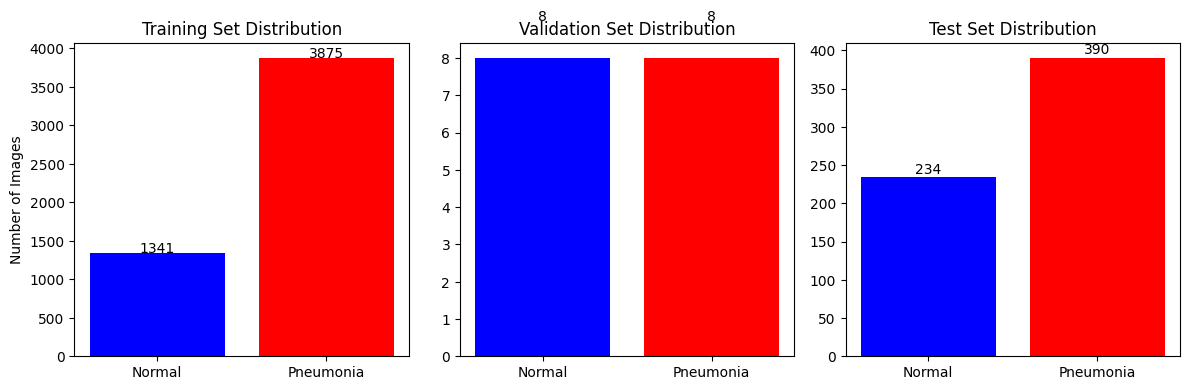

Training set: 5216 images (1341 Normal, 3875 Pneumonia)
Validation set: 16 images (8 Normal, 8 Pneumonia)
Test set: 624 images (234 Normal, 390 Pneumonia)


In [9]:
# Class ditribution visualization
def plot_class_distribution():

    train_counts = [sum(1 for label in train_ds.labels if label == 0),
                   sum(1 for label in train_ds.labels if label == 1)]

    val_counts = [sum(1 for label in val_ds.labels if label == 0),
                 sum(1 for label in val_ds.labels if label == 1)]

    test_counts = [sum(1 for label in test_ds.labels if label == 0),
                  sum(1 for label in test_ds.labels if label == 1)]

    plt.figure(figsize=(12, 4))

    plt.subplot(1, 3, 1)
    plt.bar(['Normal', 'Pneumonia'], train_counts, color=['blue', 'red'])
    plt.title('Training Set Distribution')
    plt.ylabel('Number of Images')
    for i, count in enumerate(train_counts):
        plt.text(i, count + 5, str(count), ha='center')

    plt.subplot(1, 3, 2)
    plt.bar(['Normal', 'Pneumonia'], val_counts, color=['blue', 'red'])
    plt.title('Validation Set Distribution')
    for i, count in enumerate(val_counts):
        plt.text(i, count + 1, str(count), ha='center')

    plt.subplot(1, 3, 3)
    plt.bar(['Normal', 'Pneumonia'], test_counts, color=['blue', 'red'])
    plt.title('Test Set Distribution')
    for i, count in enumerate(test_counts):
        plt.text(i, count + 5, str(count), ha='center')

    plt.tight_layout()
    plt.show()

    print(f"Training set: {len(train_ds)} images ({train_counts[0]} Normal, {train_counts[1]} Pneumonia)")
    print(f"Validation set: {len(val_ds)} images ({val_counts[0]} Normal, {val_counts[1]} Pneumonia)")
    print(f"Test set: {len(test_ds)} images ({test_counts[0]} Normal, {test_counts[1]} Pneumonia)")

plot_class_distribution()

The dataset shows moderate imbalance ratio which is typical for medical diagnosis datasets.

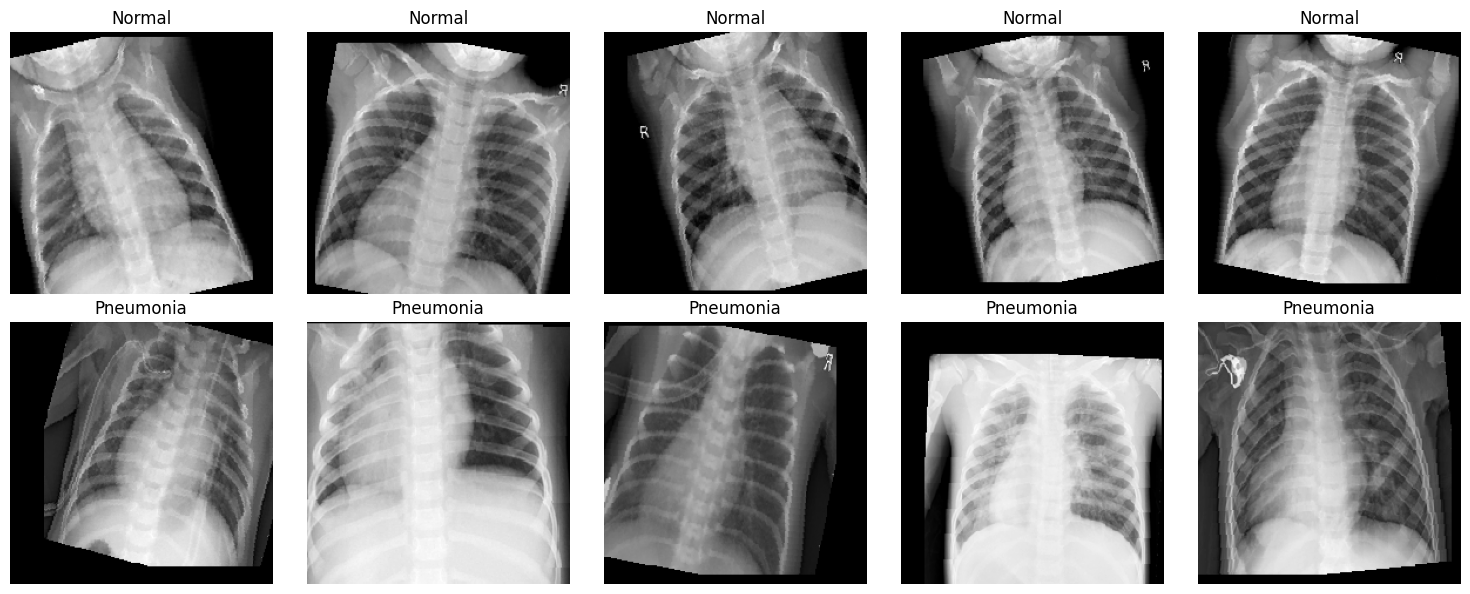

In [10]:
# Sample image visualization
def plot_sample_images():
    fig, axes = plt.subplots(2, 5, figsize=(15, 6))

    # Get first 5 processed normal and pneumonia images
    normal_indices = [i for i in range(len(train_ds)) if train_ds.labels[i] == 0][:5]
    pneumonia_indices = [i for i in range(len(train_ds)) if train_ds.labels[i] == 1][:5]

    # Processed normal samples
    for i, idx in enumerate(normal_indices):
        image, label = train_ds[idx]  # Get processed image
        if isinstance(image, torch.Tensor):
            image = image.numpy()[0]  # Remove channel dimension
        axes[0, i].imshow(image, cmap='gray')
        axes[0, i].set_title('Normal', fontsize=12)
        axes[0, i].axis('off')

    # Processed pneumonia samples
    for i, idx in enumerate(pneumonia_indices):
        image, label = train_ds[idx]  # Get processed image
        if isinstance(image, torch.Tensor):
            image = image.numpy()[0]  # Remove channel dimension
        axes[1, i].imshow(image, cmap='gray')
        axes[1, i].set_title('Pneumonia', fontsize=12)
        axes[1, i].axis('off')

    plt.tight_layout()
    plt.show()

plot_sample_images()

The sample images show that Pneumonia cases (bottom row) often have increased opacity/whitening in lung areas compared to normal X-rays (top row).

Normal pixels: 501760
Pneumonia pixels: 501760
Should be equal: True

Dark pixels (0-50 range):
Normal: 133632 pixels (26.6%)
Pneumonia: 114153 pixels (22.8%)
Normal has 17.1% more dark pixels (133632 vs 114153)


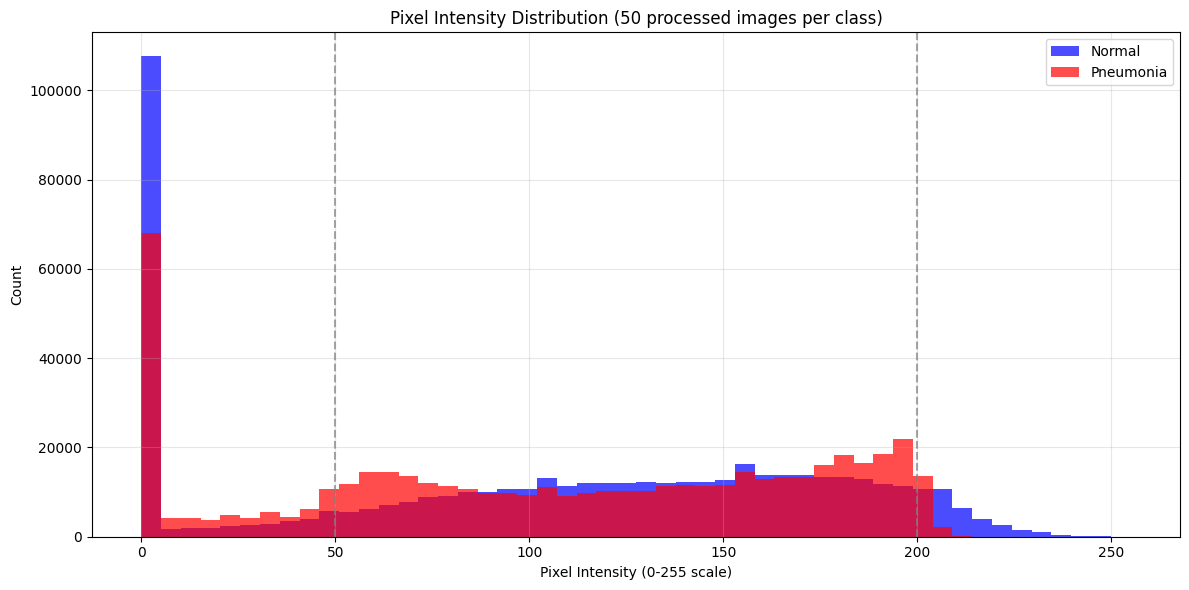

In [12]:
# Pixel intensity distribution
def plot_pixel_count_distribution():
    # Get first 10 processed images from each class
    normal_indices = [i for i in range(len(train_ds)) if train_ds.labels[i] == 0][:10]
    pneumonia_indices = [i for i in range(len(train_ds)) if train_ds.labels[i] == 1][:10]

    # Collect pixels from processed images (already resized and normalized)
    normal_pixels = []
    pneumonia_pixels = []

    for idx in normal_indices:
        image, label = train_ds[idx]
        if isinstance(image, torch.Tensor):
            image = image.numpy()
        normal_pixels.extend(image.ravel())

    for idx in pneumonia_indices:
        image, label = train_ds[idx]
        if isinstance(image, torch.Tensor):
            image = image.numpy()
        pneumonia_pixels.extend(image.ravel())

    # Convert to arrays
    normal_pixels = np.array(normal_pixels)
    pneumonia_pixels = np.array(pneumonia_pixels)

    # Since images are normalized to [-1, 1], convert back to [0, 255] for interpretation
    normal_pixels = (normal_pixels + 1) * 127.5
    pneumonia_pixels = (pneumonia_pixels + 1) * 127.5

    print(f"Normal pixels: {len(normal_pixels)}")
    print(f"Pneumonia pixels: {len(pneumonia_pixels)}")
    print(f"Should be equal: {len(normal_pixels) == len(pneumonia_pixels)}")

    # Count dark pixels (0-50 range)
    normal_dark = np.sum((normal_pixels >= 0) & (normal_pixels <= 50))
    pneumonia_dark = np.sum((pneumonia_pixels >= 0) & (pneumonia_pixels <= 50))

    print(f"\nDark pixels (0-50 range):")
    print(f"Normal: {normal_dark} pixels ({normal_dark/len(normal_pixels)*100:.1f}%)")
    print(f"Pneumonia: {pneumonia_dark} pixels ({pneumonia_dark/len(pneumonia_pixels)*100:.1f}%)")
    print(f"Normal has {(normal_dark / pneumonia_dark - 1) * 100:.1f}% more dark pixels ({normal_dark} vs {pneumonia_dark})")

    plt.figure(figsize=(12, 6))

    plt.hist(normal_pixels, bins=50, alpha=0.7, color='blue', label='Normal')
    plt.hist(pneumonia_pixels, bins=50, alpha=0.7, color='red', label='Pneumonia')

    plt.title('Pixel Intensity Distribution (50 processed images per class)')
    plt.xlabel('Pixel Intensity (0-255 scale)')
    plt.ylabel('Count')
    plt.legend()
    plt.grid(True, alpha=0.3)

    # Add vertical lines for key ranges
    plt.axvline(50, color='gray', linestyle='--', alpha=0.7)
    plt.axvline(200, color='gray', linestyle='--', alpha=0.7)

    plt.tight_layout()
    plt.savefig('pixel_intensity_histograms.png', dpi=300, bbox_inches='tight')
    plt.show()

plot_pixel_count_distribution()

The pixel intensity histograms reveal different value distributions between classes. Pneumonia images (red) show shifted intensity profiles toward mid-range values (50 - 200) which is likely reflecting fluid/infection (more bright) patterns compared to normal cases (blue) which has lots of dark areas.

#3- Models Development & Evaluation

In [5]:
import torch.nn as nn
from monai.networks.nets import DenseNet121
import torch.optim as optim
from torch.cuda.amp import autocast, GradScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, ConfusionMatrixDisplay

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [6]:
# PyTorch Model -> (Custom)
class PneumoniaCNN(nn.Module):
    def __init__(self):
        super(PneumoniaCNN, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(1, 32, 3, padding=1),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.MaxPool2d(2),

            nn.Conv2d(32, 64, 3, padding=1),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.MaxPool2d(2),

            nn.Conv2d(64, 128, 3, padding=1),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.MaxPool2d(2),

            nn.AdaptiveAvgPool2d(1)
        )
        self.classifier = nn.Linear(128, 2)
        self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.dropout(x)
        x = self.classifier(x)
        return x

# create the model instance
custom_model = PneumoniaCNN().to(device)

# set up loss and optimizer
normal_count = 234
pneumonia_count = 390
total = normal_count + pneumonia_count
class_weights = torch.tensor([total/normal_count, total/pneumonia_count]).to(device)
criterion = nn.CrossEntropyLoss(weight=class_weights)
optimizer = optim.Adam(custom_model.parameters(), lr=1e-4, weight_decay=1e-5)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=2, factor=0.5)

def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=5, threshold=0.55):
    scaler = torch.amp.GradScaler('cuda')
    best_val_loss = float('inf')
    best_epoch = -1

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0

        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()

            with torch.amp.autocast('cuda'):
                outputs = model(inputs)
                loss = criterion(outputs, labels)

            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()

            running_loss += loss.item()

        model.eval()
        val_loss = 0.0
        val_preds = []
        val_labels = []

        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                val_loss += loss.item()

                probs = torch.softmax(outputs, dim=1)
                preds = (probs[:, 1] > threshold).long()
                val_preds.extend(preds.cpu().numpy())
                val_labels.extend(labels.cpu().numpy())

        avg_val_loss = val_loss / len(val_loader)
        val_recall = recall_score(val_labels, val_preds, zero_division=0)

        print(f"Epoch {epoch+1}/{num_epochs}, "
              f"Train Loss: {running_loss/len(train_loader):.4f}, "
              f"Val Loss: {avg_val_loss:.4f}, "
              f"Val Recall: {val_recall:.4f}")

        scheduler.step(avg_val_loss)

        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            best_epoch = epoch + 1
            torch.save({
                'epoch': best_epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'val_loss': best_val_loss
            }, "best_custom_model.pth")
            print(f"Saved model from Epoch {best_epoch} with Val Loss: {best_val_loss:.4f}")

    return best_val_loss

def evaluate_model(model, data_loader, model_name, threshold=0.7):
    model.eval()
    all_preds = []
    all_probs = []
    all_labels = []

    with torch.no_grad():
        for inputs, labels in data_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            probs = torch.softmax(outputs, dim=1)

            # Use custom threshold for medical safety
            preds = (probs[:, 1] > threshold).long()  # Predict pneumonia only if confident

            all_preds.extend(preds.cpu().numpy())
            all_probs.extend(probs.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    accuracy = accuracy_score(all_labels, all_preds)
    precision = precision_score(all_labels, all_preds)
    recall = recall_score(all_labels, all_preds)
    f1 = f1_score(all_labels, all_preds)
    roc_auc = roc_auc_score(all_labels, np.array(all_probs)[:, 1])
    confusion_mat = confusion_matrix(all_labels, all_preds)

    print(f"\n{model_name} Evaluation (Threshold: {threshold}):")
    print(f"Accuracy:  {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall:    {recall:.4f}")
    print(f"F1-Score:  {f1:.4f}")
    print(f"ROC AUC:   {roc_auc:.4f}")
    disp = ConfusionMatrixDisplay(confusion_matrix=confusion_mat, display_labels=['Normal', 'Pneumonia'])
    disp.plot()
    plt.show()

    # Show prediction distribution
    unique_preds, pred_counts = np.unique(all_preds, return_counts=True)
    class_names = {0: 'Normal', 1: 'Pneumonia'}
    prediction_counts = {class_names[k]: v for k, v in zip(unique_preds, pred_counts)}
    print(f"Predictions: Normal: {prediction_counts.get('Normal', 0)}, Pneumonia: {prediction_counts.get('Pneumonia', 0)}")

    return accuracy, precision, recall, f1, roc_auc, confusion_mat

In [16]:
# MONAI Model -> (Pretrained)
def create_pretrained_model():
    model = DenseNet121(
        spatial_dims=2,
        in_channels=3,
        out_channels=2,
        pretrained=True
    ).to(device)
    return model

monai_transforms = transforms.Compose([
    transforms.Grayscale(num_output_channels=3),  # MONAI expects 3 channels (RGB)
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # ImageNet stats
])

def create_monai_test_loader():
    monai_test_ds = ChestXRayDataset(test_dir, transform=monai_transforms, user_path=andrew_path)
    monai_test_loader = DataLoader(monai_test_ds, batch_size=32, num_workers=2)
    return monai_test_loader

monai_test_loader = create_monai_test_loader()

def evaluate_pretrained_monai(model, data_loader, model_name, threshold=0.7):
    model.eval()
    all_preds = []
    all_probs = []
    all_labels = []

    with torch.no_grad():
        for inputs, labels in data_loader:
            # Convert to MONAI-compatible format
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            probs = torch.softmax(outputs, dim=1)
            preds = (probs[:, 1] > threshold).long()

            all_preds.extend(preds.cpu().numpy())
            all_probs.extend(probs.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # Calculate metrics...
    accuracy = accuracy_score(all_labels, all_preds)
    precision = precision_score(all_labels, all_preds, zero_division=0)
    recall = recall_score(all_labels, all_preds, zero_division=0)
    f1 = f1_score(all_labels, all_preds, zero_division=0)
    roc_auc = roc_auc_score(all_labels, np.array(all_probs)[:, 1])
    confusion_mat = confusion_matrix(all_labels, all_preds)

    print(f"\n{model_name} Evaluation (Threshold: {threshold}):")
    print(f"Accuracy:  {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall:    {recall:.4f}")
    print(f"F1-Score:  {f1:.4f}")
    print(f"ROC AUC:   {roc_auc:.4f}")
    disp = ConfusionMatrixDisplay(confusion_matrix=confusion_mat, display_labels=['Normal', 'Pneumonia'])
    disp.plot()
    plt.show()

    return accuracy, precision, recall, f1, roc_auc, confusion_mat

Found 624 images in /content/drive/MyDrive/6- CMPE 257 Machine Learning/Final Project/data/chest_xray/test


Training custom model...
Epoch 1/3, Train Loss: 0.6135, Val Loss: 0.7106, Val Recall: 0.8750
Saved model from Epoch 1 with Val Loss: 0.7106
Epoch 2/3, Train Loss: 0.5988, Val Loss: 0.7224, Val Recall: 1.0000
Epoch 3/3, Train Loss: 0.5824, Val Loss: 0.7240, Val Recall: 1.0000
Loaded best model from Epoch 1 with Val Loss: 0.7106

Custom CNN (Best Val Loss) Evaluation (Threshold: 0.55):
Accuracy:  0.7788
Precision: 0.7986
Recall:    0.8641
F1-Score:  0.8300
ROC AUC:   0.8541


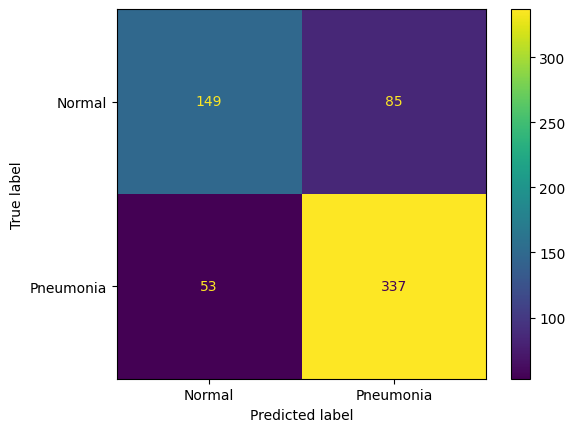

Predictions: Normal: 202, Pneumonia: 422


In [26]:
# Training & Evaluation
print("Training custom model...")
custom_val_loss = train_model(custom_model, train_loader, val_loader, criterion, optimizer, num_epochs=3)

# Load the best model for testing
checkpoint = torch.load("best_custom_model.pth")
custom_model.load_state_dict(checkpoint['model_state_dict'])
print(f"Loaded best model from Epoch {checkpoint['epoch']} with Val Loss: {checkpoint['val_loss']:.4f}")

# Evaluate on test set
custom_metrics = evaluate_model(custom_model, test_loader, "Custom CNN (Best Val Loss)", threshold=0.55)


Evaluating pre-trained model...

Pre-trained DenseNet121 Evaluation (Threshold: 0.6):
Accuracy:  0.6154
Precision: 0.6238
Recall:    0.9692
F1-Score:  0.7590
ROC AUC:   0.3922


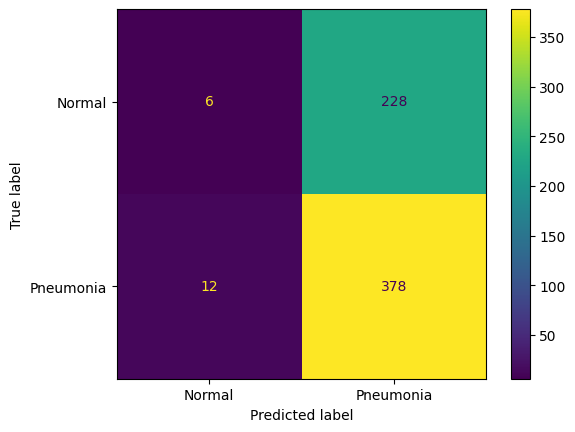

In [25]:
print("\nEvaluating pre-trained model...")
pretrained_model = create_pretrained_model()
pretrained_metrics = evaluate_pretrained_monai(pretrained_model, monai_test_loader, "Pre-trained DenseNet121", threshold=0.6)

In [41]:
# Define minimum acceptable thresholds
recall_threshold = 0.6
precision_threshold = 0.5

# Check if both models meet minimum safety thresholds
pretrained_passes = pretrained_metrics[2] >= recall_threshold and pretrained_metrics[1] >= precision_threshold
custom_passes = custom_metrics[2] >= recall_threshold and custom_metrics[1] >= precision_threshold

# Select based on F1-score and ROC AUC if both pass
if pretrained_passes and custom_passes:
    if custom_metrics[3] > pretrained_metrics[3] and custom_metrics[4] > pretrained_metrics[4]:
        final_model = custom_model
        best_model_name = "Custom CNN"
    else:
        final_model = pretrained_model
        best_model_name = "Pre-trained DenseNet121"

# If only one passes, select that one
elif custom_passes:
    final_model = custom_model
    best_model_name = "Custom CNN"
elif pretrained_passes:
    final_model = pretrained_model
    best_model_name = "Pre-trained DenseNet121"

# If neither passes, fallback to highest ROC AUC
else:
    if custom_metrics[4] > pretrained_metrics[4]:
        final_model = custom_model
        best_model_name = "Custom CNN"
    else:
        final_model = pretrained_model
        best_model_name = "Pre-trained DenseNet121"

print(f"\nFinal model selected: {best_model_name}")
torch.save(final_model, os.path.join(andrew_path, 'Final Project/final_pneumonia_model_full.pth'))


Final model selected: Custom CNN


#4- Model Interpretability with Grad-CAM

In [17]:
from PIL import Image
import matplotlib.pyplot as plt
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.image import show_cam_on_image

def visualize_gradcam(model, image_path, true_label, threshold=0.55, known=False, model_type='custom'):
    # Load image
    image = Image.open(image_path).convert('L')

    # Preprocess based on model type
    if model_type == 'custom':
        image = image.resize((224, 224))
        input_tensor = val_transforms(image).unsqueeze(0).to(device)
        target_layers = [model.features[-3]]
    elif model_type == 'pretrained':
        image_rgb = image.convert('RGB')  # MONAI expects 3 channels
        image_rgb = image_rgb.resize((224, 224))
        input_tensor = monai_transforms(image_rgb).unsqueeze(0).to(device)
        target_layers = [model.features.denseblock4]  # MONAI DenseNet target layer

    # Get prediction
    model.eval()
    with torch.no_grad():
        outputs = model(input_tensor)
        probs = torch.softmax(outputs, dim=1)
        prediction = (probs[:, 1] > threshold).long().item()

    # Grad-CAM
    cam = GradCAM(model=model, target_layers=target_layers)
    grayscale_cam = cam(input_tensor=input_tensor, targets=None)[0]

    # Prepare image for overlay
    img_np = np.array(image.resize((224, 224))) / 255.0
    img_rgb = np.stack([img_np]*3, axis=-1)

    visualization = show_cam_on_image(img_rgb, grayscale_cam, use_rgb=True)

    # Plot
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 3, 1)
    plt.imshow(img_np, cmap='gray')
    title = f'True: {"Pneumonia" if true_label else "Normal"}\nOriginal X-Ray' if known else 'Original X-Ray'
    plt.title(title)
    plt.axis('off')

    plt.subplot(1, 3, 2)
    plt.imshow(grayscale_cam, cmap='jet')
    plt.title('Grad-CAM Heatmap')
    plt.axis('off')

    plt.subplot(1, 3, 3)
    plt.imshow(visualization)
    plt.title(f'Pred: {"Pneumonia" if prediction else "Normal"}\nConf: {probs[0,prediction].item():.2f}')
    plt.axis('off')

    plt.tight_layout()
    plt.savefig('gradcam_example.png', dpi=300, bbox_inches='tight')
    plt.show()

    return prediction, probs[0,prediction].item()

#5- ML App

Saving NORMAL2-IM-0051-0001.jpeg to NORMAL2-IM-0051-0001.jpeg
Uploaded NORMAL2-IM-0051-0001.jpeg


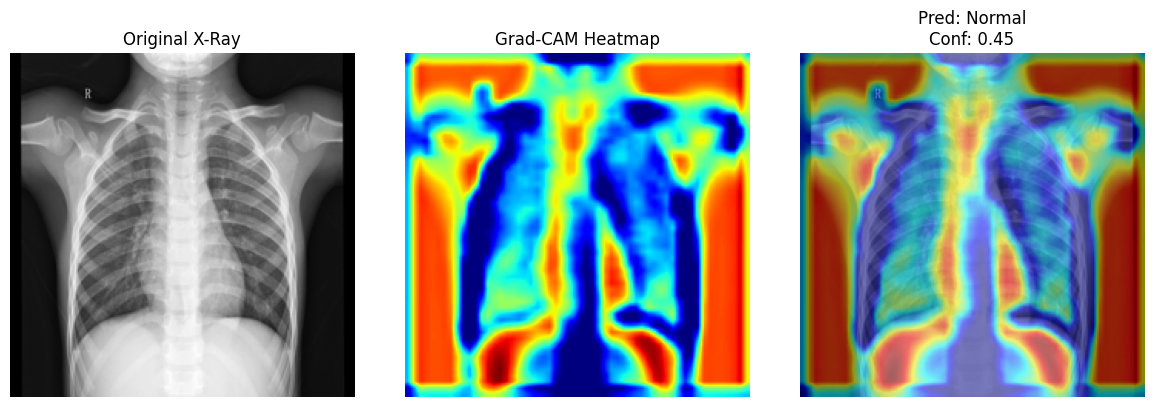


Prediction: Normal (Confidence: 0.45)


In [20]:
import os
from google.colab import files
from pathlib import Path
import random
import torch.serialization
from monai.networks.nets import DenseNet121

andrew_path = '/content/drive/MyDrive/6- CMPE 257 Machine Learning/'

# Load final model
torch.serialization.add_safe_globals([DenseNet121])  # Allow MONAI class
final_model = torch.load(os.path.join(andrew_path, 'Final Project/final_pneumonia_model_full.pth'), weights_only=False)
final_model.eval()

# Upload or select image
user_path = andrew_path
dir = Path(os.path.join(user_path, 'Final Project/data'))
all_files = list(dir.glob('**/*.jpeg'))

upload = files.upload()
if upload:
    for fn in upload.keys():
        print(f'Uploaded {fn}')
        image_path = fn
else:
    print('No file uploaded. Using a random image from dataset.')
    image_path = random.choice(all_files)
    print(f'Selected image: {image_path.name}')

# Run Grad-CAM visualization
prediction, confidence = visualize_gradcam(final_model, image_path, true_label=None, known=False, model_type='custom')
print(f"\nPrediction: {'Pneumonia' if prediction else 'Normal'} (Confidence: {confidence:.2f})")